In [1]:
!pip install scikit-learn

In [2]:
import pennylane as qml
from pennylane import numpy as np
from braket.aws import AwsDevice

from typing import List

import data_loader as dl

from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import math

import json

In [3]:
def inspect_classification_boundaries(
    variational_classifier, 
    params,
    plot_range: float,
    train_coordinates = None,
    train_labels = None,
    grid_size: int = 30,
    save_fig: bool = False,
    fig_name: str = None,
):
    assert grid_size % 2 == 0, "Please input an even grid_size"
    
    x_range = [2 * plot_range * j / grid_size for j in range(-grid_size // 2, grid_size // 2 + 1, 1)]
    y_range = x_range
    grid_data = np.array([[j, k] for j in x_range for k in y_range])
    predictions = [variational_classifier_linear(params, f) for f in grid_data.reshape(-1, 1, 2)]
    pred_labels = 1 * (np.array(predictions) > 0.5)
    #plt.scatter(x=grid_data[:,0], y=grid_data[:,1], c=pred_labels)
    #plt.show()
    if (train_coordinates is not None) and (train_labels is not None):
        plt.scatter(x=train_coordinates.reshape(-1,2)[:,0], y=train_coordinates.reshape(-1,2)[:,1], c=train_labels)
    plt.contourf(x_range, y_range, pred_labels.reshape(grid_size + 1, grid_size + 1).T, levels=[-0.1, 0.5, 1.1], alpha=0.4)
    if save_fig:
        plt.savefig(fig_name)
    plt.show()

Get devices

In [4]:
# multiple criteria can be applied
#AwsDevice.get_devices(statuses=['ONLINE'])

In [5]:
#s3 = ("my-bucket", "my-prefix")
# device = qml.device("braket.aws.qubit", device_arn="arn:aws:braket:::device/qpu/rigetti/Aspen-9", s3_destination_folder=s3, wires=n_wires)

Define local device

In [6]:
n_wires = 2

In [7]:
local_simulator = qml.device(
    "braket.local.qubit", 
    wires=n_wires,
    shots=256,
)
local_simulator

<BraketLocalQubitDevice device (wires=2, shots=256) at 0x7fa42497ef90>

In [8]:
#device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
#s3_folder = ("amazon-braket-amazon-braket-qhack-reply-2021", "pennylane-variational")
#sv1_simulator = qml.device(
#    "braket.aws.qubit",
#    device_arn=device_arn,
#    wires=n_wires,
#    s3_destination_folder=s3_folder,
#    parallel=True,
#    shots=256,
#)
#sv1_simulator

Circuit architecture

In [9]:
@qml.template
def custom_ansatz(weights, wires):
    for w in weights:
        for i, wire in enumerate(wires):
            qml.RY(w[wire], wires=wire)
            qml.CZ(wires=(i, i + 1)) if i + 1 < len(wires) else qml.CNOT(wires=(i, 0))

In [10]:
def circuit(params, features):
    #qml.templates.BasicEntanglerLayers(features, wires=range(n_wires)) # This works well
    qml.templates.AngleEmbedding(features[0], wires=range(n_wires))
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_wires))
    #qml.templates.BasicEntanglerLayers(params, wires=range(n_wires))
    #custom_ansatz(params, wires=range(n_wires))
    return qml.expval(qml.PauliZ(0))

In [11]:
simulated_circuit = qml.QNode(circuit, local_simulator)

Wrappers to rescale circuit output between 0 and 1

In [12]:
def variational_classifier_sigmoid(params, features):
    meas = simulated_circuit(params, features)
    sigmoid = 1 / (1 + np.exp(-5 * meas))
    return sigmoid

In [13]:
def variational_classifier_linear(params, features):
    meas = simulated_circuit(params, features)
    rescaled = (meas + 1) / 2
    return rescaled

In [14]:
n_variational_layers = 4
np.random.seed(2165)
initial_params = qml.init.strong_ent_layers_normal(n_variational_layers, n_wires)
#initial_params = qml.init.basic_entangler_layers_normal(n_variational_layers, n_wires)
variational_classifier_linear(initial_params, [[0.2] * n_wires])

tensor(0.9921875, requires_grad=True)

Loss and cost functions for the VQC

In [15]:
def logloss(predictions: List[float], labels: List[int]) -> float:
    loss = 0
    for p, lab in zip(predictions, labels):
        loss += - lab * np.log(p) - (1 - lab) * np.log(1 - p) 
    return loss / len(labels)

In [16]:
def squareloss(predictions: List[float], labels: List[int]) -> float:
    loss = 0
    for p, lab in zip(predictions, labels):
        loss += (p - lab)**2 
    return loss / len(labels)

In [17]:
def logloss_cost(params, features: List[List[float]], labels: List[int]) -> float:
    predictions = [variational_classifier_sigmoid(params, f) for f in features]
    return logloss(predictions, labels)

In [18]:
def squareloss_cost(params, features: List[List[float]], labels: List[int]) -> float:
    predictions = [variational_classifier_linear(params, f) for f in features]
    return squareloss(predictions, labels)

Load data

In [19]:
n_components = n_wires
train_df, test_df = dl.load_train_test_pca(n_components)

max_value = np.max(abs(train_df.values))
plot_range = 6

train_df.iloc[:,:-1] = train_df.iloc[:,:-1] * plot_range / max_value
test_df.iloc[:,:-1] = test_df.iloc[:,:-1] * plot_range / max_value

train_coordinates = train_df.iloc[:,:-1].values.reshape(-1, 1, n_components)
train_labels = train_df.label
test_coordinates = test_df.iloc[:,:-1].values.reshape(-1, 1, n_components)
test_labels = test_df.label

In [20]:
train_df.describe()

,pca_1,pca_2,label
count,3.048000e+03,3.048000e+03,3048.000000
mean,1.165588e-17,-2.797412e-17,0.433071
std,1.287546e+00,1.287546e+00,0.495582
min,-3.368621e+00,-4.180838e+00,0.000000
25%,-1.010511e+00,-8.738734e-01,0.000000
50%,-2.030708e-01,-3.321542e-02,0.000000
75%,1.062712e+00,8.483037e-01,1.000000
max,3.820439e+00,6.000000e+00,1.000000


In [21]:
np.min(train_coordinates), np.max(train_coordinates)

(-4.180838361325919, 6.0)

In [22]:
np.min(test_coordinates), np.max(test_coordinates)

(-5.161646392167743, 4.508957258387234)

Initialize random parameters for the variational part of the circuits

In [23]:
n_variational_layers = 4
np.random.seed(2175)
initial_params = qml.init.strong_ent_layers_normal(n_variational_layers, n_wires)
#initial_params = qml.init.basic_entangler_layers_normal(n_variational_layers, n_wires)

Optimize

In [24]:
import os
folder = f"results/4strongent_scale{plot_range}"
if not os.path.exists(folder):
    os.makedirs(folder)

In [25]:
opt = qml.NesterovMomentumOptimizer(0.05)
#opt = qml.QNGOptimizer()

Step: 0, Cost:  0.34896148681640626


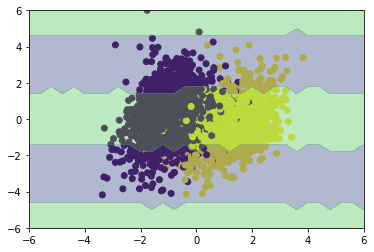

Step: 10, Cost:  0.3310569763183594


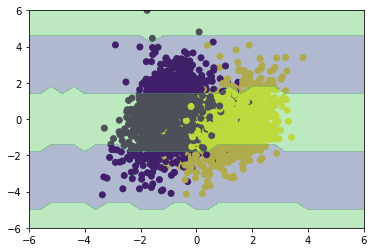

Step: 20, Cost:  0.21937973022460938


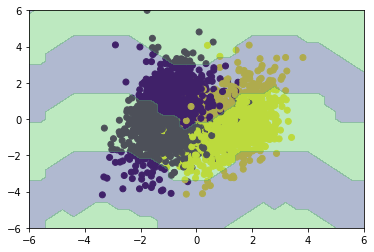

Step: 30, Cost:  0.23163177490234374


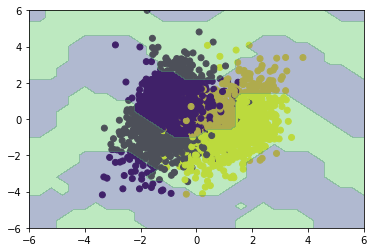

Step: 40, Cost:  0.13782546997070313


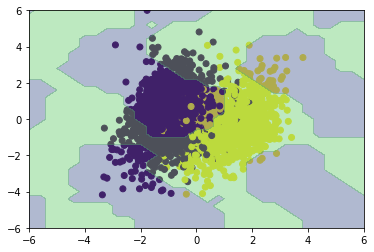

Final cost: 0.13782546997070313


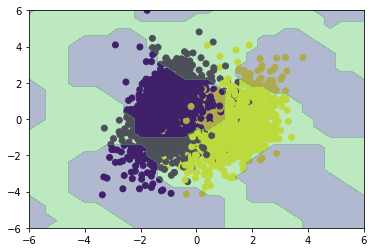

In [26]:
params = initial_params

batch_size = 100

n_iterations = 40
for j in range(n_iterations + 1):
    #print(j)
    # Get a batch of data
    batch_idx = np.random.choice(range(len(train_labels)), batch_size, replace=False)
    batch_features = train_coordinates[batch_idx]
    batch_labels = train_labels[batch_idx]

    params, prev_cost = opt.step_and_cost(lambda p: squareloss_cost(p, batch_features, batch_labels), params)
    
    current_cost = squareloss_cost(params, batch_features, batch_labels)
    if j % 10 == 0:
        print(f"Step: {j}, Cost: ", current_cost)
        
        inspect_classification_boundaries(
            variational_classifier_linear, 
            params,
            plot_range=plot_range,
            train_coordinates=train_coordinates,
            train_labels=train_labels,
            grid_size=30,
            save_fig=True,
            fig_name=f"{folder}/step_{j}.png",
        )    
    #if abs(current_cost - prev_cost) < 0.001 or current_cost < 0.3:
    #    break
print(f"Final cost: {current_cost}")
inspect_classification_boundaries(
    variational_classifier_linear, 
    params,
    plot_range=plot_range,
    train_coordinates=train_coordinates,
    train_labels=train_labels,
    grid_size=30,
    save_fig=True,
    fig_name=f"{folder}/step_{n_iterations}.png",
)    

In [27]:
circuit = {
    "n_wires": n_wires,
    "structure": """AngleEmbedding(features[0], wires=range(n_wires))
    BasicEntanglerLayers(params, wires=range(n_wires))
    ExpVal(PauliZ(0))""",
    "params": params.numpy().tolist()
}
with open(f"{folder}/circuit.json", "w") as f:
    f.write(json.dumps(circuit))

In [28]:
train_predictions = [variational_classifier_linear(params, f) for f in train_coordinates]
test_predictions = [variational_classifier_linear(params, f) for f in test_coordinates]

In [29]:
pred_labels = 1 * (np.array(train_predictions) > 0.5)

print(confusion_matrix(y_true=train_labels, y_pred=pred_labels))

print(classification_report(y_true=train_labels, y_pred=pred_labels))

[[1332  396]
 [ 229 1091]]
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1728
           1       0.73      0.83      0.78      1320

    accuracy                           0.79      3048
   macro avg       0.79      0.80      0.79      3048
weighted avg       0.80      0.79      0.80      3048



In [30]:
results_train = {
    "confusion_matrix_train": repr(confusion_matrix(y_true=train_labels, y_pred=pred_labels)),
    "classification_report_train": repr(classification_report(y_true=train_labels, y_pred=pred_labels))
}
with open(f"{folder}/results_train.json", "w") as f:
    f.write(json.dumps(results_train))

In [31]:
pred_labels = 1 * (np.array(test_predictions) > 0.5)

print(confusion_matrix(y_true=test_labels, y_pred=pred_labels))

print(classification_report(y_true=test_labels, y_pred=pred_labels))

[[350 102]
 [ 57 253]]
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       452
           1       0.71      0.82      0.76       310

    accuracy                           0.79       762
   macro avg       0.79      0.80      0.79       762
weighted avg       0.80      0.79      0.79       762



In [32]:
results_test = {
    "confusion_matrix_test": repr(confusion_matrix(y_true=test_labels, y_pred=pred_labels)),
    "classification_report_test": repr(classification_report(y_true=test_labels, y_pred=pred_labels))
}
with open(f"{folder}/results_test.json", "w") as f:
    f.write(json.dumps(results_test))

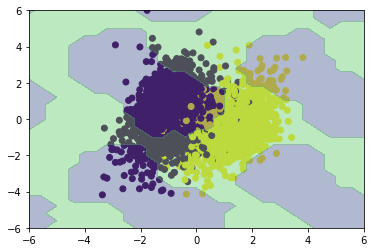

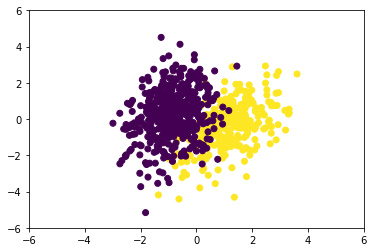

In [33]:
inspect_classification_boundaries(
    variational_classifier_linear, 
    params,
    plot_range=plot_range,
    train_coordinates=train_coordinates,
    train_labels=train_labels,
    grid_size=30,
)    

plt.scatter(x=test_coordinates.reshape(-1,2)[:,0], y=test_coordinates.reshape(-1,2)[:,1], c=test_labels)
plt.xlim(-plot_range,plot_range)
plt.ylim(-plot_range,plot_range)
plt.show()

Classical comparison

In [34]:
X_train = train_coordinates.reshape(-1, n_components)
X_test = test_coordinates.reshape(-1, n_components)
y_train = train_labels
y_test = test_labels

clf = svm.SVC()
clf.fit(X_train, y_train)
 
pred_classic = clf.predict(X_train)
print(confusion_matrix(y_true=train_labels, y_pred=pred_classic))
print(classification_report(y_true=train_labels, y_pred=pred_classic))

pred_classic = clf.predict(X_test)
print(confusion_matrix(y_true=test_labels, y_pred=pred_classic))
print(classification_report(y_true=test_labels, y_pred=pred_classic))

[[1621  107]
 [ 119 1201]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1728
           1       0.92      0.91      0.91      1320

    accuracy                           0.93      3048
   macro avg       0.92      0.92      0.92      3048
weighted avg       0.93      0.93      0.93      3048

[[420  32]
 [ 31 279]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       452
           1       0.90      0.90      0.90       310

    accuracy                           0.92       762
   macro avg       0.91      0.91      0.91       762
weighted avg       0.92      0.92      0.92       762



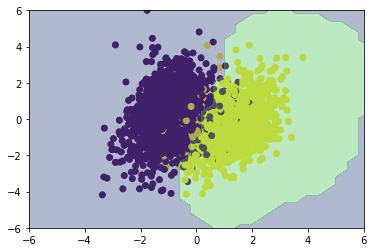

In [35]:
grid_size = 30
x_range = [2 * plot_range * j / grid_size for j in range(-grid_size // 2, grid_size // 2 + 1, 1)]
y_range = x_range
grid_data = np.array([[j, k] for j in x_range for k in y_range])
predictions = clf.predict(grid_data)
pred_labels = 1 * (np.array(predictions) > 0.5)

plt.scatter(x=train_coordinates.reshape(-1,2)[:,0], y=train_coordinates.reshape(-1,2)[:,1], c=train_labels)
plt.contourf(x_range, y_range, pred_labels.reshape(grid_size + 1, grid_size + 1).T, levels=[-0.1, 0.5, 1.1], alpha=0.4)
plt.show()

In [36]:
#energy_expval = qml.ExpvalCost(circuit, h, simulator, optimize=True)